In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
f = r.TFile("./data/results_10MissingOutputFiles_9day_histOnly.root")
f.ls()

TFile**		./data/results_10MissingOutputFiles_9day_histOnly.root	
 TFile*		./data/results_10MissingOutputFiles_9day_histOnly.root	
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences (ClusterAndCoincidenceHistograms) folder
  KEY: TDirectoryFile	clustersAndCoincidencesTrunc;1	clustersAndCoincidencesTrunc (ClusterAndCoincidenceHistograms) folder
  KEY: TDirectoryFile	farline;1	farline (CaloFarlineHistograms) folder
  KEY: TDirectoryFile	farlineTrunc;1	farlineTrunc (CaloFarlineHistograms) folder
  KEY: TDirectoryFile	clusterCompare;1	clusterCompare (ReconComparisonTruncatedVsFull) folder


In [4]:
f.cd("clustersAndCoincidences")
f.ls()

TFile**		./data/results_10MissingOutputFiles_9day_histOnly.root	
 TFile*		./data/results_10MissingOutputFiles_9day_histOnly.root	
  TDirectoryFile*		clusterCompare	clusterCompare (ReconComparisonTruncatedVsFull) folder
   KEY: TH2D	evwEnergyEvW;1	EnergyTrunc vs. EnergyFull
   KEY: TH2D	counterHist;1	Number of Clusters Per Island in Trunc and Full
   KEY: TH2D	counterHistHighEnergy;1	Number of Clusters Per Island in Trunc and Full [All Clusters Above Energy Cutoff]
   KEY: TH2D	evwDeltaXDeltaY;1	Energy Weighted #deltaX vs. #deltaY
   KEY: TH2D	evwDeltaTCalo;1	Energy Weighted #deltaT
   KEY: TH1D	evwDeltaE;1	#deltaE (n:n Islands Only: n > 0)
   KEY: TH1D	evwDeltaEAll;1	#deltaE (All Islands: n,m > 0)
   KEY: TH2D	counterFullVsTime;1	Number of Clusters Per Island in Recon Full vs. t_{full} (Max Energy)
   KEY: TH2D	counterTruncVsTime;1	Number of Clusters Per Island in Recon Trunc vs. t_{trunc} (Max Energy)
   KEY: TH3D	counterTruncVsCounterFullVsTime;1	Number of Clusters Per Island in Reco

In [113]:
c1 = f.Get("clustersAndCoincidences").Get("clusters")
c1.GetYaxis().SetRangeUser(1700,3100)
w1 = c1.Project3D("x").Clone("w1")

c2 = f.Get("clustersAndCoincidences").Get("clusters")
c2.GetYaxis().SetRangeUser(1700,3100)
w2 = c2.Project3D("x").Clone("w2")
w2.SetLineColor(2)

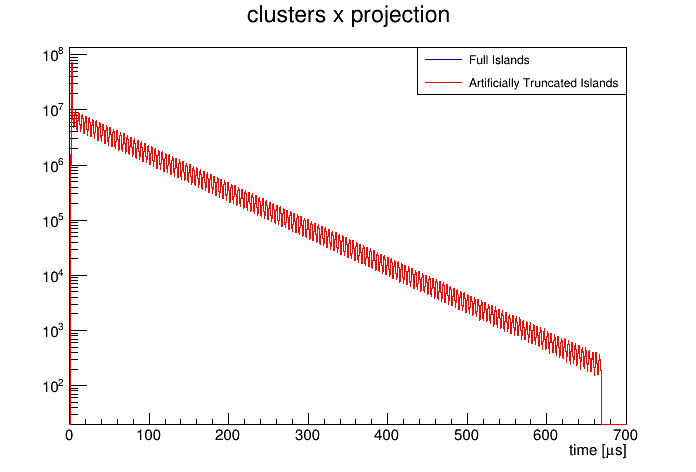

In [115]:
c = r.TCanvas()
w1.Draw()
w2.Draw("SAME")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(w1,"Full Islands")
leg.AddEntry(w2,"Artificially Truncated Islands")
leg.Draw()

c.SetLogy()
c.Draw()

In [116]:
#time bounds in microseconds within which to do all the fits
fitBoundLow = 30
fitBoundHigh = 650

---

# Lets first do a full wiggle fit of the full islands

### 5 Parameter Fit

In [153]:
# blinded instance
getBlinded = Blinders(FitType.Omega_a, 'Oh wow we have to choose a new blinding phrase, huh? This is exciting!')
def blinded_wiggle(x, p):
    norm  = p[0]
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
#    omega = myBlinder.paramToFreq(R) unblind version
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [160]:
funcFull = r.TF1("funcFull", blinded_wiggle, fitBoundLow,fitBoundHigh,5)
funcFull.SetParNames('N','#tau','A','R','#phi')
funcFull.SetParameters(7000000,64.4,0.4,-100,0)
funcFull.SetParLimits(4,-0.001 - 2*math.pi,2*math.pi+0.001)
funcFull.SetLineColor(2)
funcFull.SetNpx(2000)

Sarting fit: 1
Sarting fit: 2
 FCN=13306.2 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         548 TOTAL
                     EDM=1.30645e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.75863e+06   3.01894e+02  -1.03473e-02  -1.39139e-11
   2  #tau         6.44230e+01   1.41216e-03  -1.33933e-08   3.78747e-06
   3  A            3.70290e-01   2.91600e-05  -2.48923e-09   1.60607e-05
   4  R           -4.57862e+01   8.81454e-01   1.99406e-05  -1.99526e-08
   5  #phi        -1.06084e+00   1.44711e-04   1.44711e-04   7.77328e-04
 FCN=13306.2 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         313 TOTAL
                     EDM=1.04266e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   

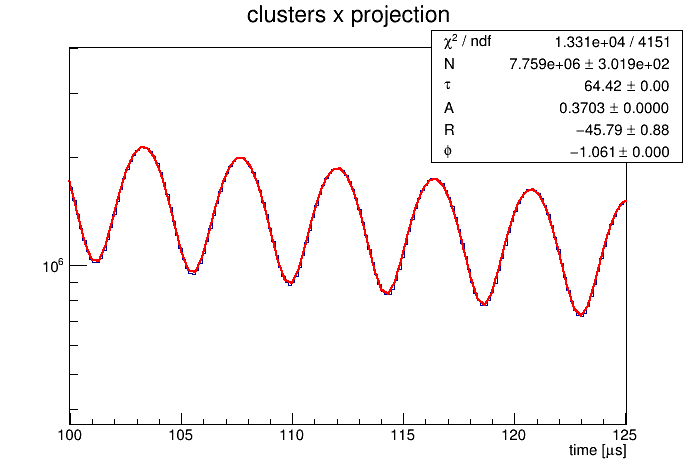

In [161]:
residualsFull_5Param = w1.Clone() # this will be filled with the fit residuals later
c2 = r.TCanvas()

for fit in range(2):
    print("Sarting fit:", fit+1)
    w1.Fit("funcFull","REM")
    
w1.Draw()

c2.cd(2)
ding =  w1.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

### 5-Param Residuals FFT

In [162]:
def fourierXformWiggle( wigglePlot, fitFunction, fitBoundLow, fitBoundHigh, title ):
    c3 = r.TCanvas()
    residualsFull_5Param = wigglePlot.Clone() 
    nBins = residualsFull_5Param.GetSize() - 2 #total number of bins excluding over/underflow
    print(nBins)
    residVec = []
    for i in range(nBins):
        binCenterX = wigglePlot.GetXaxis().GetBinCenter(i)
        if (binCenterX > fitBoundLow and binCenterX < fitBoundHigh):
            residVec.append( (binCenterX, wigglePlot.GetBinContent(i) - fitFunction.Eval(binCenterX) ) )
            residualsFull_5Param.SetBinContent(i, wigglePlot.GetBinContent(i) - fitFunction.Eval(binCenterX))
        else:
            residualsFull_5Param.SetBinContent(i, 0)

    print(len(residVec),[residVec[i] for i in range(5)])
    centers, bins = zip(*residVec)
    htest = r.TH1D("htest","htest",len(residVec),centers[0],centers[len(residVec)-1])
    for i,ding in enumerate(bins):
        htest.SetBinContent(i, ding)

    residualsFull_5Param.Delete()
    residualsFull_5Param = htest
    nBins = residualsFull_5Param.GetSize() - 2 #total number of bins excluding over/underflow

    #apply a windows function to try to get rid of the imaginary peaks
    welchVec = []
    for i in range(nBins):
        unwindowed = residualsFull_5Param.GetBinContent(i)
        welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
        welchVec.append(welch)
        residualsFull_5Param.SetBinContent(i, unwindowed *  welch)

    residualsFull_5Param.Draw()
    residualsFull_5Param.GetXaxis().SetRangeUser(30,700)
    residualsFull_5Param.SetTitle("(Windowed) Residuals of the Fit")
    c3.Draw()    

    hxform = r.TH1D()
    hxform = 0
    r.TVirtualFFT.SetTransform(0)
    hxform = residualsFull_5Param.FFT(hxform,"MAG P")
    hxform.SetTitle( title )
    #NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
    #    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
    normXform = hxform.GetEntries()
    hxform.Scale(1/normXform)
    c2 = r.TCanvas()
    c2.cd()
    #c2.SetLogy()
    hxform.GetXaxis().SetTitle("Frequency (MHz)")
    hxform.GetYaxis().SetTitle("Arb. Units")
    hxform.Draw("HIST P0 L")
    #c2.Draw()

    Npart = residualsFull_5Param.GetSize() - 2
    minBinCenter = residualsFull_5Param.GetXaxis().GetBinCenter(0)
    maxBinCenter = residualsFull_5Param.GetXaxis().GetBinCenter(Npart)

    capT = maxBinCenter - minBinCenter
    print(Npart, capT, minBinCenter, maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print(deltaT, deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
    limmaxMHz = limmaxHz / math.pow(10.0,6)

    limmax = 2*deltaF*Npart #400-25
    print(limmax,limmaxMHz)
    #hxform.GetXaxis().SetLimits(0,limmax)
    nbins = residualsFull_5Param.GetSize() - 2
    hxform.SetBins(Npart,0,limmaxMHz)
    hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    #hxform.GetXaxis().SetRangeUser(0,1.4)

    #c2.SetLogy()
    #c2.Draw()
    #c2.Print("./images/FullIslands_5ParamResiduals.png")
    #c2.Print("./images/FullIslands_5ParamResiduals.root")
    
    return hxform;

In [163]:
ding = fourierXformWiggle( w1, funcFull, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 5-Parameter Fit [Full Islands]" )
residuals5paramXform_FullIslands = ding.Clone()

4692
4156 [(30.0618073316283, -10460.033994059078), (30.21099744245524, -4443.048998535611), (30.36018755328218, -7403.480752336793), (30.50937766410912, -8480.908588845748), (30.65856777493606, 158.74103116849437)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


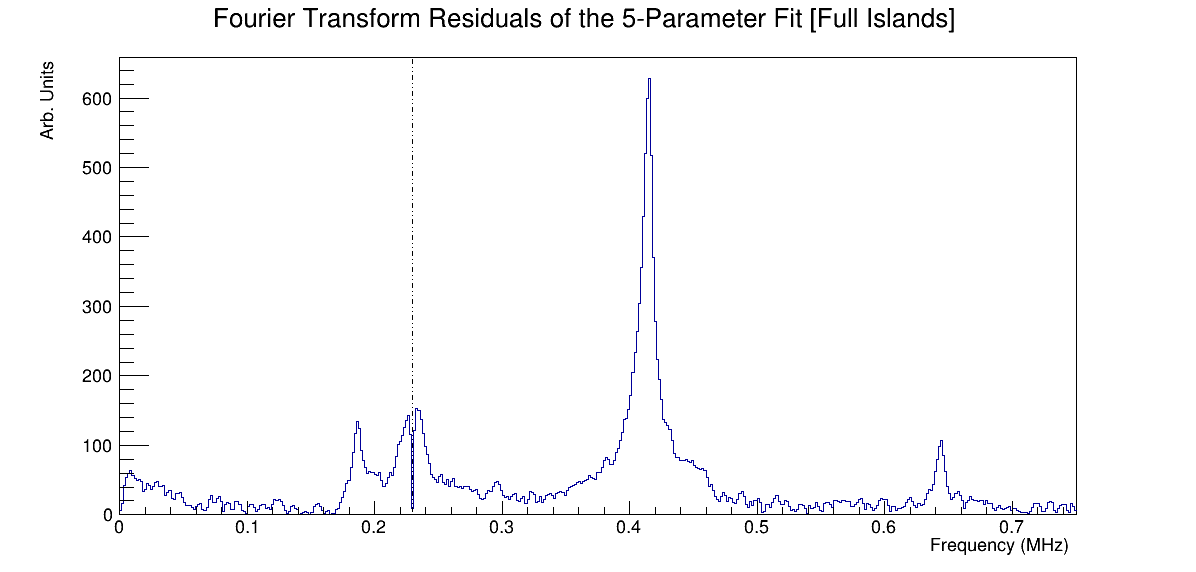

In [164]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_FullIslands.Draw("hist")

f_omega_a = r.TLine(0.23,0.0000001,0.23,655)
f_omega_a.SetLineStyle(8)
f_omega_a.Draw("SAME")


c.Draw()

---

### 13-Parameter Fit

In [24]:
def blinded_wiggle_cbo(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    
    return norm * math.exp(-time/life) * cCBO * (1 - ACBO*math.cos(omega*time + phiCBO))

In [51]:
func13Full = r.TF1("func13Full", blinded_wiggle_cbo, fitBoundLow, fitBoundHigh,13)
func13Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func13Full.SetParName(11,'#phi_{CBO - 2}')
func13Full.SetParName(12,'#phi_{CBO - 3}')
func13Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
#func13Full.SetParLimits(10,-6.3,6.3)
#func13Full.SetParLimits(11,-6.3,6.3)
#func13Full.SetParLimits(12,-6.3,6.3)


#initial guesses, then updated with the first round of fit results
func13Full.SetParameters(100000, 64.32689658986958, -0.41149191856871803, 
                     -11.31981267111425, -4.201648334505292, -0.666502391530784, 
                     0.6927259503578, -0.38908021438317, 200, 
                     2.5, 0.4745581246420292)
func13Full.SetParameter(11, 6.299934663288357)
func13Full.SetParameter(12, 0.28579778778899545)
for i in range(4):
    func13Full.SetParameter(i, funcFull.GetParameter(i))

func13Full.SetLineColor(2)
func13Full.SetNpx(2000)

Starting Fit: 1
Starting Fit: 2
 FCN=6362.65 FROM MINOS     STATUS=SUCCESSFUL    125 CALLS        4361 TOTAL
                     EDM=1.65147e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.76942e+06   3.02547e+02   1.20322e-01  -4.79349e-09
   2  #tau         6.44022e+01   1.41220e-03  -4.04720e-07  -3.19259e-04
   3  A            3.70455e-01   2.92590e-05   9.39794e-09  -1.47591e-01
   4  R           -4.42221e+01   8.83505e-01  -6.98495e-04  -1.70122e-06
   5  #phi        -7.34439e+00   1.45364e-04   1.59212e-07  -4.48486e-02
   6  A_{1}        4.12702e-03   1.03420e-04   8.60941e-08   1.62884e-01
   7  A_{2}       -1.06472e-03   1.79929e-04  -4.83205e-08  -1.00741e-02
   8  A_{3}        1.33715e-03   1.87312e-04   1.30059e-07   1.31003e-02
   9  #tau_{CBO}   1.68047e+02   9.38280e+00  -6.20301e-08   1.99581e-01
  10  #ome

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


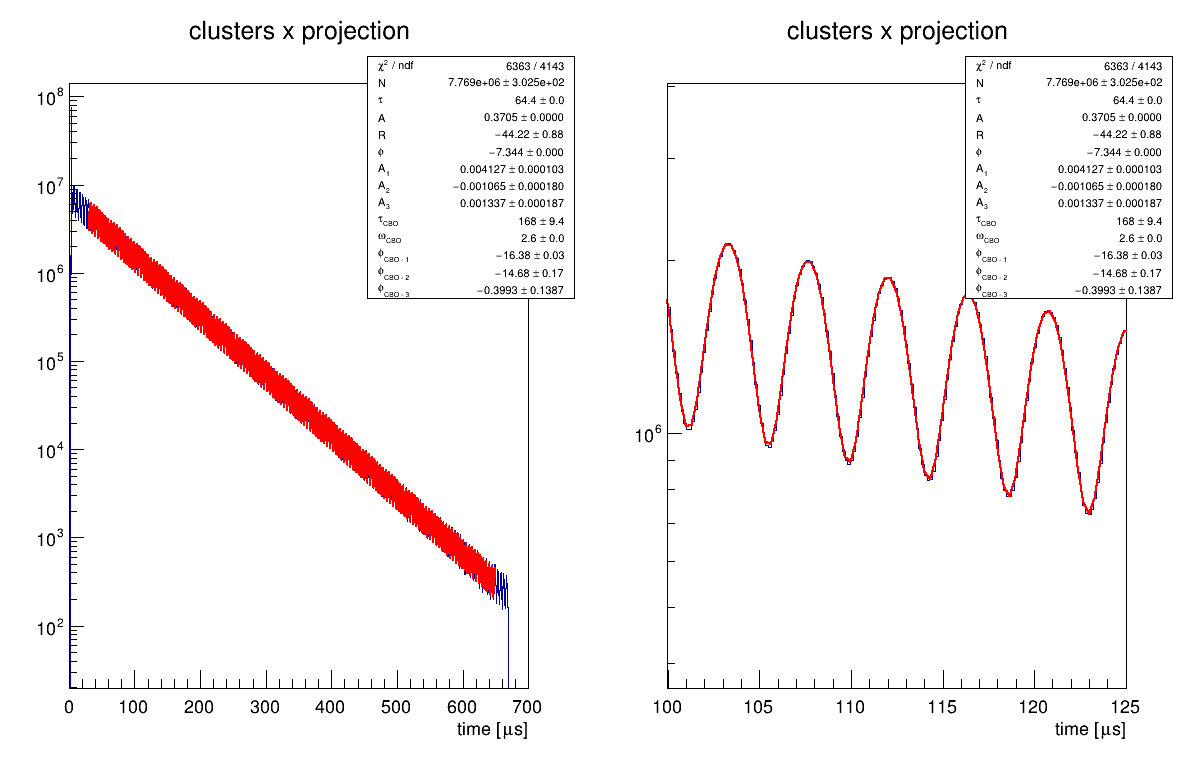

In [61]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_13 = w1.Clone()
w1_13.GetXaxis().UnZoom()

residuals13 = w1_13.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_13.Fit("func13Full","REMB")

w1_13.Draw()

c2.cd(2)
ding13 =  w1_13.Clone()
ding13.GetXaxis().SetRangeUser(100,125)
ding13.Draw()

r.gPad.SetLogy()
c2.Draw()

In [62]:
parameters13Full = []
for i in range(13):
    parameters13Full.append( (func13Full.GetParameter(i) , func13Full.GetParError(i)) )
#print(parameters13)
par13,parErr13 = zip(*parameters13Full)
print(par13)

(7769415.746410462, 64.4022168918029, 0.37045451133679846, -44.22208691378872, -7.344388961777424, 0.004127018737778069, -0.0010647218924655065, 0.0013371526030540688, 168.0475730293194, 2.599985083093492, -16.37790142368583, -14.683648711563606, -0.3992583680156577)


In [54]:
ding = fourierXformWiggle( w1, func13Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 13-Parameter Fit [Full Islands]" )
residuals13paramXform_FullIslands = ding.Clone()
residuals13paramXform_FullIslands.SetLineColor(6)

4692
4156 [(30.0618073316283, -2346.80456757918), (30.21099744245524, 7771.842112230137), (30.36018755328218, 6192.953612974845), (30.50937766410912, 4172.50960805919), (30.65856777493606, 10285.001117442735)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


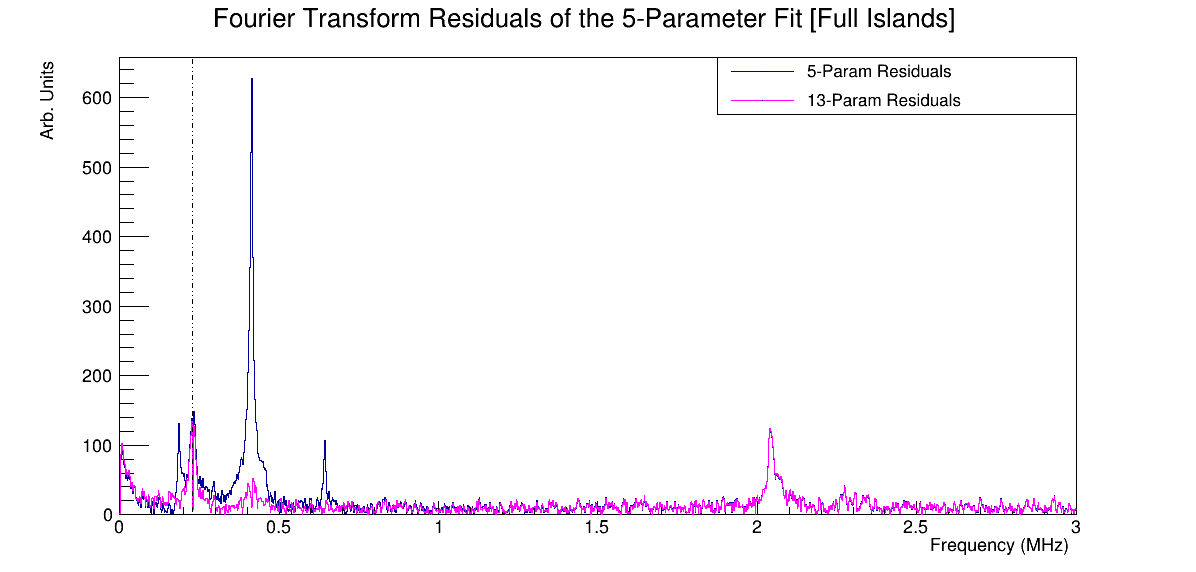

In [65]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

### 17-Parameter Fit with vertical waist term

In [66]:
def blinded_wiggle_cbo_vw(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO))

In [74]:
func17Full = r.TF1("func17Full", blinded_wiggle_cbo_vw,  fitBoundLow, fitBoundHigh,17)
func17Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func17Full.SetParName(11,'#phi_{CBO - 2}')
func17Full.SetParName(12,'#phi_{CBO - 3}')
func17Full.SetParName(13,'A_{VW}')
func17Full.SetParName(14,'#tau_{VW}')
func17Full.SetParName(15,'#omega_{VW}')
func17Full.SetParName(16,'#phi_{VW}')
func17Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func17Full.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(13):
    func17Full.SetParameter(i, func13Full.GetParameter(i))
func17Full.SetParameter(13, 0.2)
func17Full.SetParameter(14, 30)
func17Full.SetParameter(15, 12.83)
func17Full.SetParameter(16, 0)

#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func17Full.SetLineColor(4)
func17Full.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
       7769413.348273292 +/- 302.56472141940253
       64.4022260527788 +/- 0.0014122459602757876
       0.37045454256295657 +/- 2.925889897235728e-05
       -44.24479476945891 +/- 0.8835438128320888
       -7.344383707393735 +/- 0.00014537739096083066
       0.004132060039697858 +/- 0.00010369158487406729
       -0.0010678053170339384 +/- 0.00018007495148470435
       0.0013281776943487918 +/- 0.00018741544611064974
       167.7143721901773 +/- 9.363935726813807
       2.5999753423805294 +/- 0.00035078616758984647
       -16.377020026342567 +/- 0.02639024147021313
       -14.681477294764521 +/- 0.16682414016435573
       -0.401590385137332 +/- 0.13973747394473524
       0.0040774446422391026 +/- 0.0006923559914725055
       30.801224904033436 +/- 3.620124419678735
       12.829936149474277 +/- 0.00413112042162856
       -7.566102058757935 +/- 0.1819372739942559
Starting Fit: 2
     Parameters from fit 2 :
       7769413.344897589 +/- 302.56

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


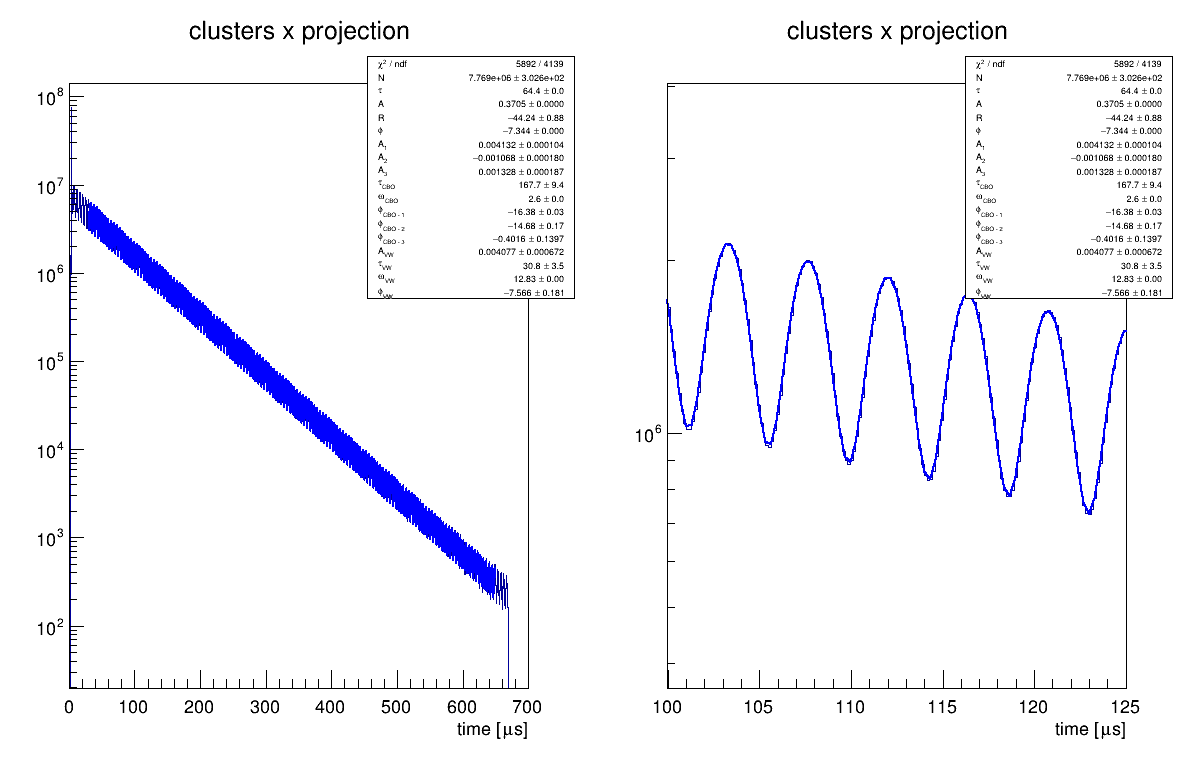

In [76]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_17 = w1.Clone()
w1_17.GetXaxis().UnZoom()

residuals17 = w1_17.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_17.Fit("func17Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func17Full.GetChiSquare() / func17Full.GetNDF() )
    for i in range(17):
        print( "      ", func17Full.GetParameter(i) ,"+/-", func17Full.GetParError(i) ) 

w1_17.Draw()

c2.cd(2)
ding17 =  w1_17.Clone()
ding17.GetXaxis().SetRangeUser(100,125)
ding17.Draw()

r.gPad.SetLogy()
c2.Draw()

In [81]:
ding = fourierXformWiggle( w1, func17Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 17-Parameter Fit [Full Islands]" )
residuals17paramXform_FullIslands = ding.Clone()
residuals17paramXform_FullIslands.SetLineColor(3)

4692
4156 [(30.0618073316283, 1088.6644751653075), (30.21099744245524, 470.338931995444), (30.36018755328218, 7894.7557654660195), (30.50937766410912, 9293.741707790643), (30.65856777493606, 5781.8326575271785)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


In [82]:
parameters17Full = []
for i in range(17):
    parameters17Full.append( (func17Full.GetParameter(i) , func17Full.GetParError(i)) )
#print(parameters13)
par17,parErr17 = zip(*parameters17Full)
print(par17)

(7769413.344897589, 64.40222605517849, 0.3704545429809088, -44.244796723851145, -7.344383707898687, 0.004132053745848027, -0.0010678027755189625, 0.0013281654386228478, 167.71421298974667, 2.5999753505084207, -16.377019453282582, -14.681483852825185, -0.4015895691085909, 0.004077405946655821, 30.801079570288397, 12.829936096608288, -7.56610115226242)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


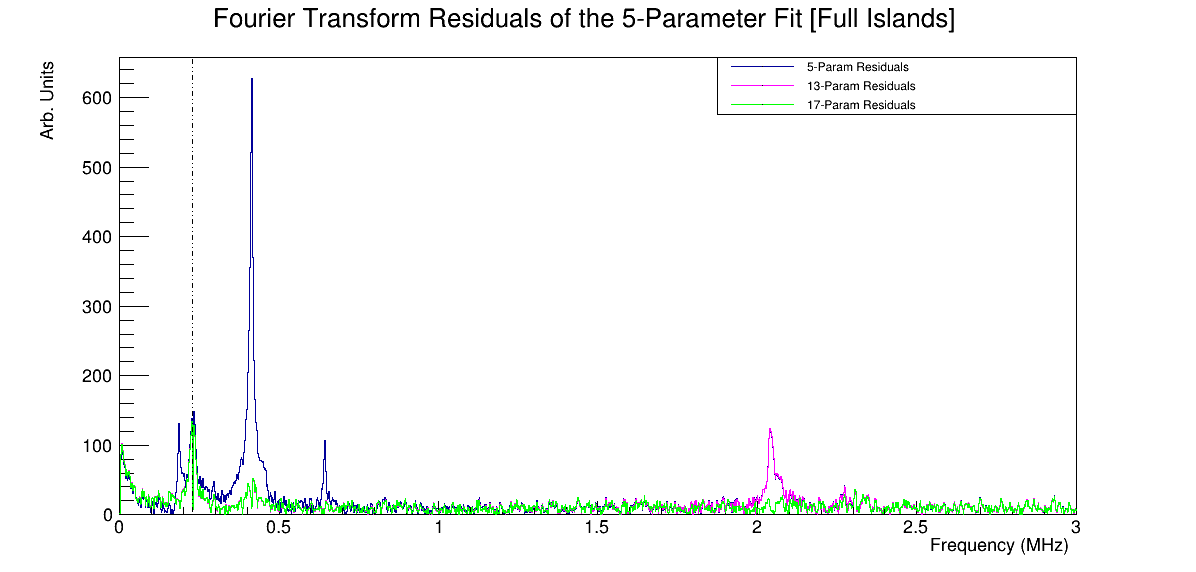

In [84]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


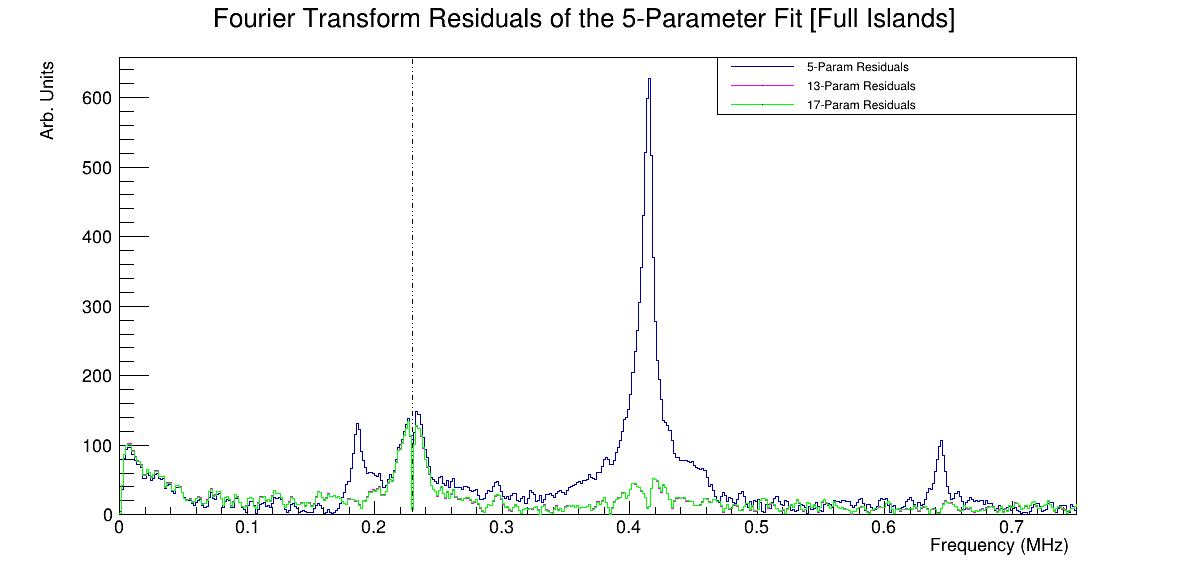

In [85]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


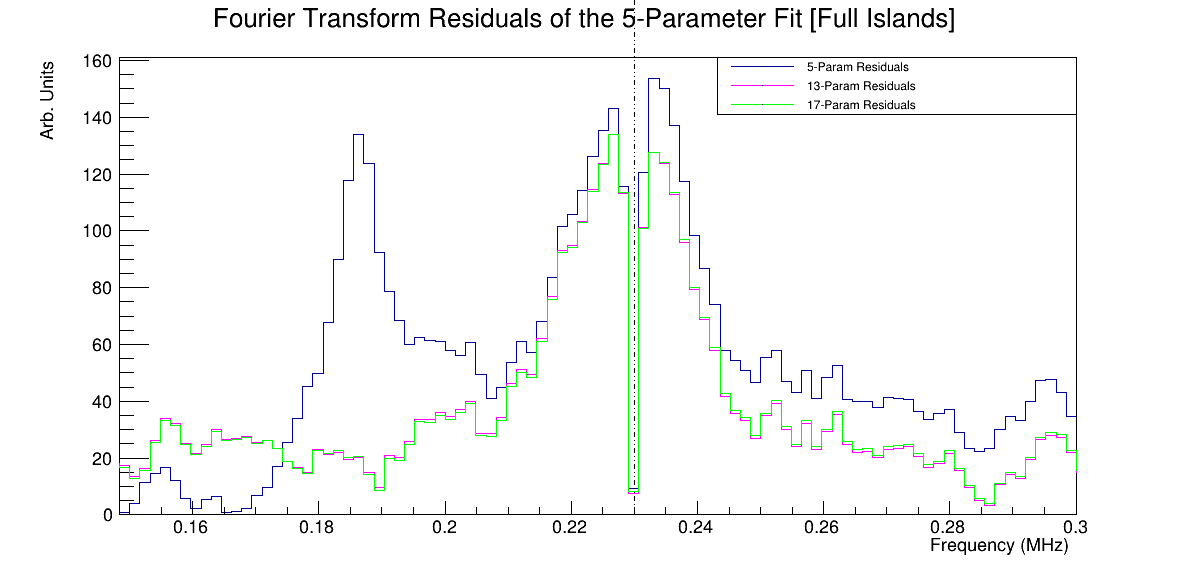

In [165]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0.15,0.3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

# And now onto the truncated version

### 5-Parameter Fit

In [166]:
funcTrunc = r.TF1("funcTrunc", blinded_wiggle, fitBoundLow,fitBoundHigh,5)
funcTrunc.SetParNames('N','#tau','A','R','#phi')
funcTrunc.SetParameters(7000000,64.4,0.4,0,0)
funcTrunc.SetParLimits(4,-0.001 - 2*math.pi,2*math.pi+0.001)
funcTrunc.SetLineColor(2)
funcTrunc.SetNpx(2000)

Sarting fit: 1
Sarting fit: 2
 FCN=13306.2 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         385 TOTAL
                     EDM=8.70298e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.75863e+06   3.01894e+02  -3.40705e-03  -1.16267e-11
   2  #tau         6.44230e+01   1.41216e-03  -2.23770e-07   7.28579e-05
   3  A            3.70290e-01   2.91600e-05  -1.15447e-08   7.80883e-05
   4  R           -4.57866e+01   8.81453e-01   2.28515e-04  -6.98340e-08
   5  #phi        -1.06084e+00   1.44711e-04   1.44711e-04   2.91559e-03
 FCN=13306.2 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         282 TOTAL
                     EDM=1.733e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1 

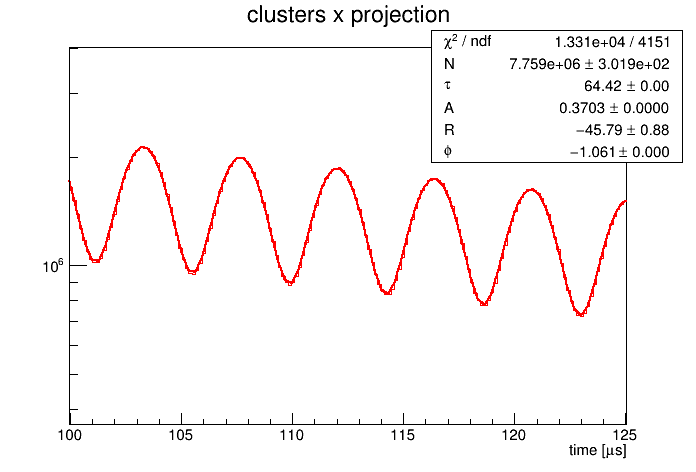

In [167]:
residualsTrunc_5Param = w2.Clone() # this will be filled with the fit residuals later
c2 = r.TCanvas()

for fit in range(2):
    print("Sarting fit:", fit+1)
    w2.Fit("funcTrunc","REM")

chiSqFivePar_Full = ( ( funcTrunc.GetNDF(),
                        funcTrunc.GetChisquare(),
                        funcTrunc.GetProb() ) )
    
w2.Draw()

c2.cd(2)
ding =  w2.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

### 5-Param Residuals FFT

In [168]:
ding = fourierXformWiggle( w2, funcTrunc, fitBoundLow, fitBoundHigh, 
                          "Fourier Transform Residuals of the 5-Parameter Fit [Truncated Islands]" )
residuals5paramXform_TruncIslands = ding.Clone()

4692
4156 [(30.0618073316283, -10459.97581310384), (30.21099744245524, -4442.987643351778), (30.36018755328218, -7403.418468371034), (30.50937766410912, -8480.84764945181), (30.65856777493606, 158.79842862393707)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


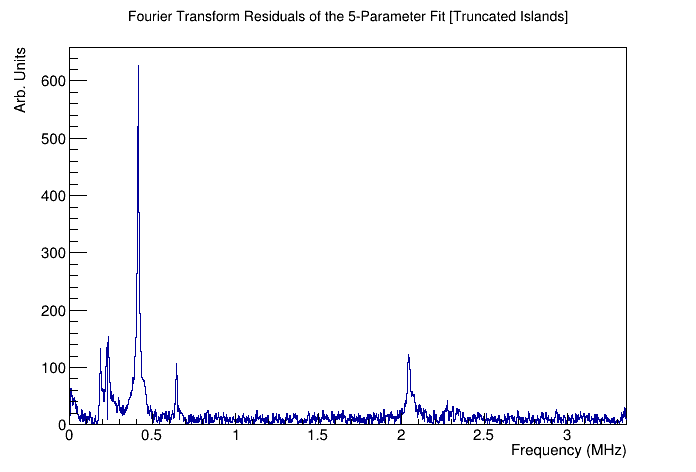

In [169]:
c = r.TCanvas()
residuals5paramXform_TruncIslands.Draw("hist")
c.Draw()

---

### 13-Parameter Fit

In [170]:
func13Trunc = r.TF1("func13Trunc", blinded_wiggle_cbo, fitBoundLow, fitBoundHigh,13)
func13Trunc.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func13Trunc.SetParName(11,'#phi_{CBO - 2}')
func13Trunc.SetParName(12,'#phi_{CBO - 3}')
func13Trunc.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
#func13Trunc.SetParLimits(10,-6.3,6.3)
#func13Trunc.SetParLimits(11,-6.3,6.3)
func13Trunc.SetParLimits(12,-6.3,6.3)


#initial guesses, then updated with the first round of fit results
func13Trunc.SetParameters(100000, 64.32689658986958, -0.41149191856871803, 
                     -11.31981267111425, -4.201648334505292, -0.666502391530784, 
                     0.6927259503578, -0.38908021438317, 220, 
                     2.5, 0.4745581246420292)
func13Trunc.SetParameter(11, 6.299934663288357)
func13Trunc.SetParameter(12, 0.28579778778899545)
for i in range(4):
    func13Trunc.SetParameter(i, funcTrunc.GetParameter(i))

func13Trunc.SetLineColor(2)
func13Trunc.SetNpx(2000)

Starting Fit: 1
Starting Fit: 2
 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 FUNCTION MUST BE MINIMIZED BEFORE CALLING MINOs     
 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                   

Warning in <Fit>: Abnormal termination of minimization.


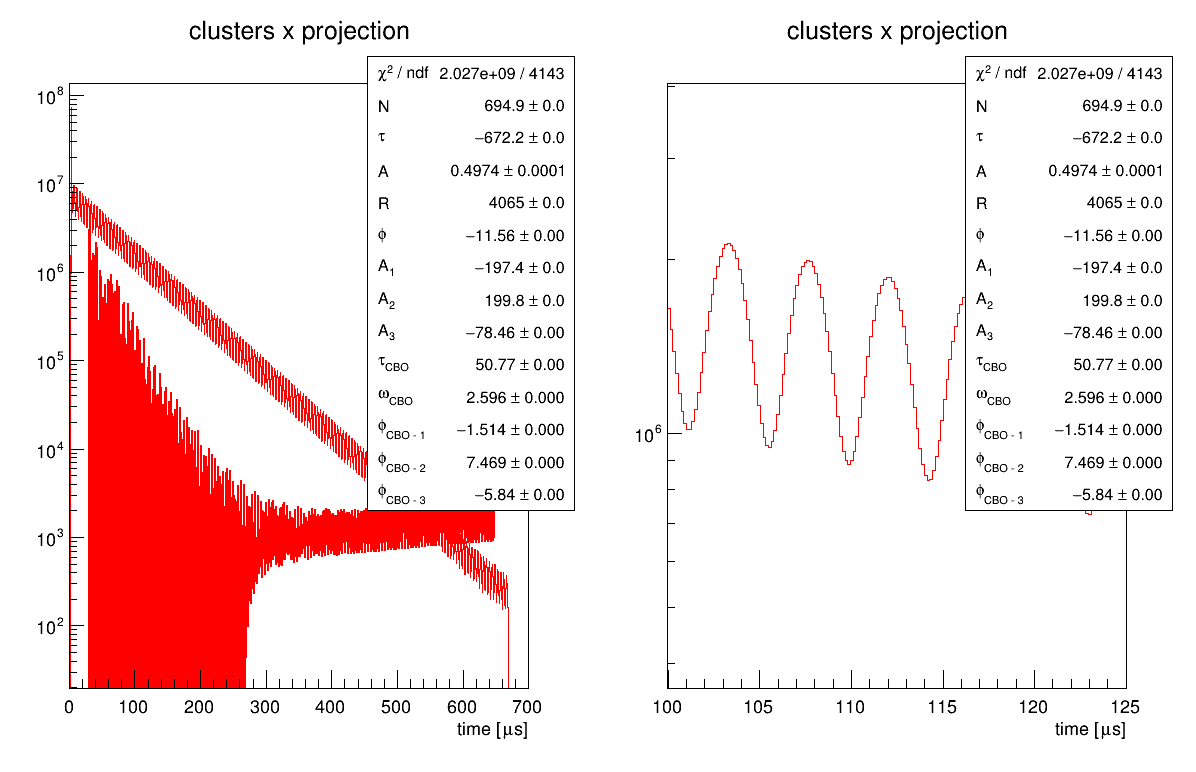

In [171]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w2_13 = w2.Clone()
w2_13.GetXaxis().UnZoom()

residuals13 = w2_13.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w2_13.Fit("func13Trunc","REMB")

w2_13.Draw()

c2.cd(2)
ding13 =  w2_13.Clone()
ding13.GetXaxis().SetRangeUser(100,125)
ding13.Draw()

r.gPad.SetLogy()
c2.Draw()

In [172]:
parameters13Trunc = []
for i in range(13):
    parameters13Trunc.append( (func13Trunc.GetParameter(i) , func13Trunc.GetParError(i)) )
#print(parameters13)
par13,parErr13 = zip(*parameters13Trunc)
print(par13)

(694.8911331206431, -672.1953516366746, 0.4973964708195577, 4064.93338370391, -11.564636932749464, -197.40887901683348, 199.8355936615128, -78.45729771094338, 50.76561779290495, 2.5964599054235618, -1.5141129138709428, 7.469235880934443, -5.840098639002698)


In [173]:
ding = fourierXformWiggle( w2, func13Trunc, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 13-Parameter Fit [Truncated Islands]" )
residuals13paramXform_TruncIslands = ding.Clone()
residuals13paramXform_TruncIslands.SetLineColor(6)

4692
4156 [(30.0618073316283, 6596745.351456443), (30.21099744245524, 4732004.091353153), (30.36018755328218, 4453775.782524197), (30.50937766410912, 4518461.660485318), (30.65856777493606, 2380698.906755447)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


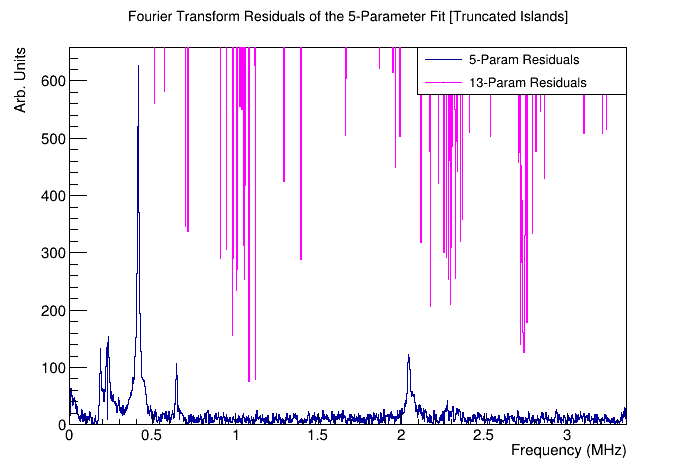

In [174]:
c = r.TCanvas()
residuals5paramXform_TruncIslands.Draw("hist")
residuals13paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
leg.Draw()

c.Draw()

---

### and now 17-param (finally)

In [175]:
func17Trunc = r.TF1("func17Trunc", blinded_wiggle_cbo_vw,  fitBoundLow, fitBoundHigh,17)
func17Trunc.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func17Trunc.SetParName(11,'#phi_{CBO - 2}')
func17Trunc.SetParName(12,'#phi_{CBO - 3}')
func17Trunc.SetParName(13,'A_{VW}')
func17Trunc.SetParName(14,'#tau_{VW}')
func17Trunc.SetParName(15,'#omega_{VW}')
func17Trunc.SetParName(16,'#phi_{VW}')
func17Trunc.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func17Trunc.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Trunc.SetParLimits(10,-6.3,6.3) 
#func17Trunc.SetParLimits(11,-6.3,6.3)
#func17Trunc.SetParLimits(12,-6.3,6.3)
#func17Trunc.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(13):
    func17Trunc.SetParameter(i, func13Full.GetParameter(i))
func17Trunc.SetParameter(13, 0.2)
func17Trunc.SetParameter(14, 30)
func17Trunc.SetParameter(15, 12.83)
func17Trunc.SetParameter(16, 0)


#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func17Trunc.SetLineColor(4)
func17Trunc.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
       7759088.553006915 +/- 302.22043250910696
       64.42155548375462 +/- 0.001412904154830109
       0.37033642966075997 +/- 2.927335672004364e-05
       -44.307842427922274 +/- 0.8838344874583146
       -7.3443609374006575 +/- 0.00014546550473229858
       0.0041550116709250665 +/- 0.00010435327984553765
       0.0010471676994260899 +/- 0.00018068735972136236
       0.0012908260703566588 +/- 0.00018785942957350485
       166.5360958636695 +/- 9.261515884761977
       2.5999578935662844 +/- 0.00035050032555631043
       -16.371184186202026 +/- 0.026320623786018783
       -11.500785332472965 +/- 0.17070536859965474
       -0.36868936680689385 +/- 0.14423548426681834
       0.004033704837753033 +/- 0.0006848295541031302
       30.969983183606292 +/- 3.653917282631088
       12.83002108277755 +/- 0.004136376315115844
       -7.573683049879927 +/- 0.18241734752185987
Starting Fit: 2
     Parameters from fit 2 :
       7759088.554614026 +/- 3

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


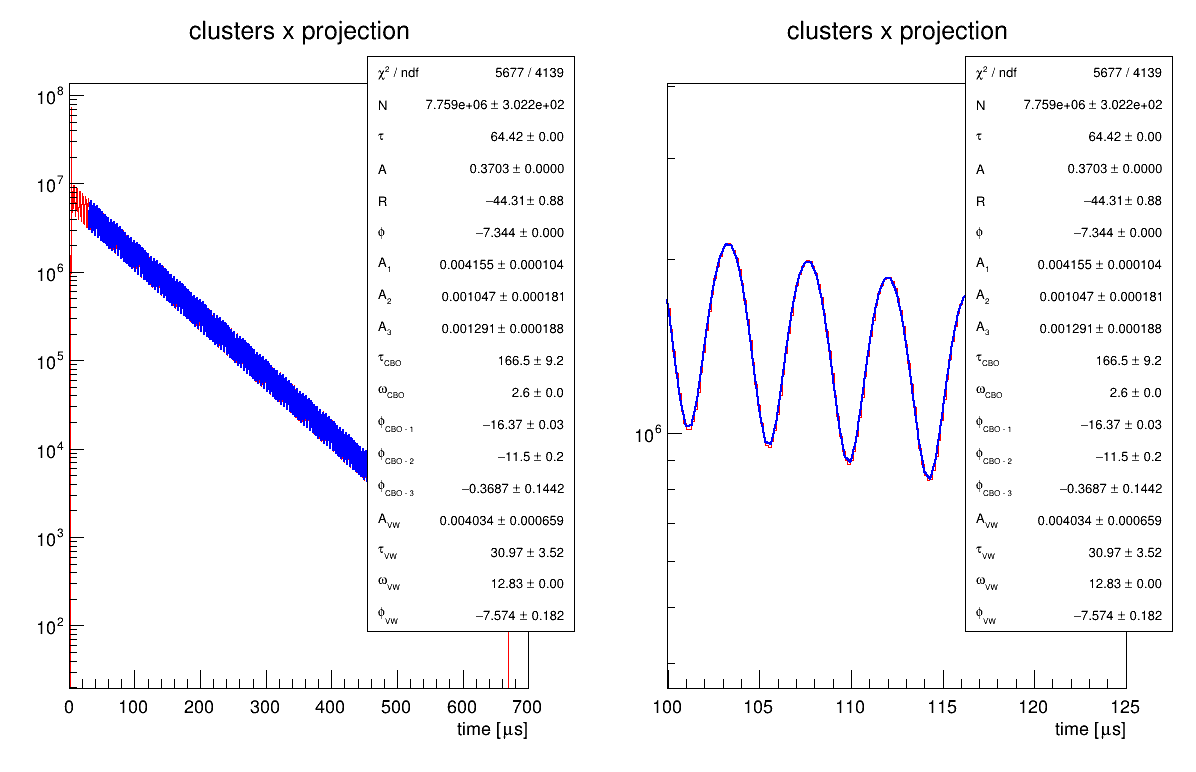

In [176]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w2_17 = w2.Clone()
w2_17.GetXaxis().UnZoom()

residuals17 = w2_17.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w2_17.Fit("func17Trunc","REMB")
    print("     Parameters from fit", i+1,":")
    for i in range(17):
        print( "      ", func17Trunc.GetParameter(i) ,"+/-", func17Trunc.GetParError(i) ) 

w2_17.Draw()

c2.cd(2)
ding17 =  w2_17.Clone()
ding17.GetXaxis().SetRangeUser(100,125)
ding17.Draw()

r.gPad.SetLogy()
c2.Draw()

In [177]:
ding = fourierXformWiggle( w2, func17Trunc, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 17-Parameter Fit [Trunc Islands]" )
residuals17paramXform_TruncIslands = ding.Clone()
residuals17paramXform_TruncIslands.SetLineColor(3)

4692
4156 [(30.0618073316283, -348.55063278693706), (30.21099744245524, -987.5849995147437), (30.36018755328218, 6555.393673324026), (30.50937766410912, 8244.337776453234), (30.65856777493606, 4880.013259287924)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TDirectoryFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


In [178]:
parameters17Trunc = []
for i in range(17):
    parameters17Trunc.append( (func17Trunc.GetParameter(i) , func17Trunc.GetParError(i)) )
#print(parameters13)
par17,parErr17 = zip(*parameters17Trunc)
print(par17)

(7759088.554614026, 64.42155548474453, 0.370336429767946, -44.30784531577958, -7.344360939185793, 0.004155013531571088, 0.0010471754581128075, 0.0012908279537617387, 166.53622181847163, 2.599957889197569, -16.371184452461154, -11.500788552867784, -0.36869151808286676, 0.004033708209892692, 30.97001083371072, 12.830021112970664, -7.573681484931814)


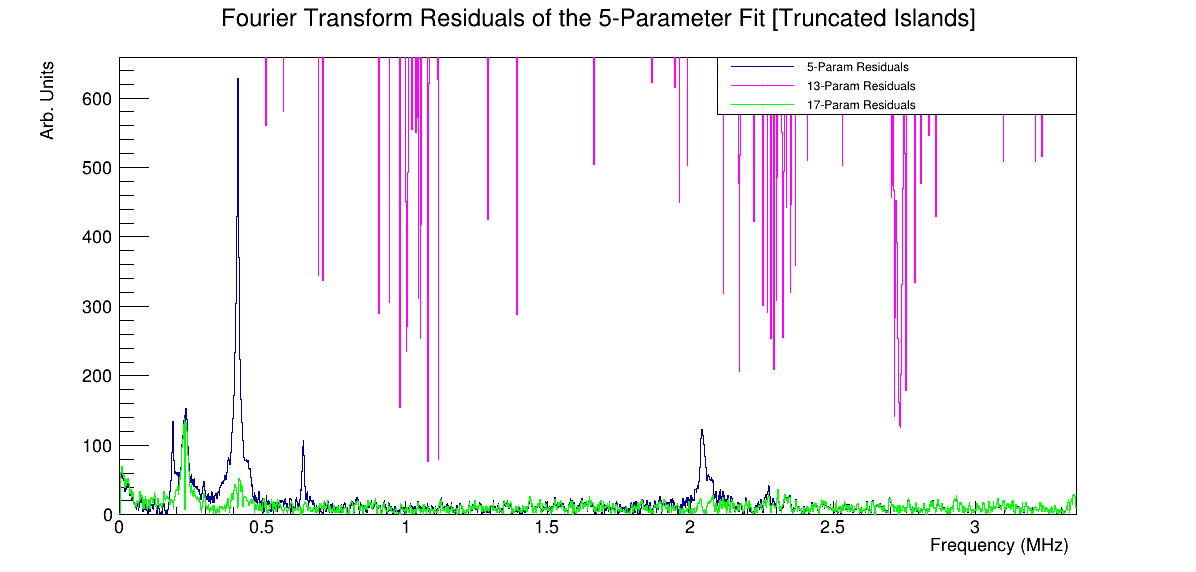

In [179]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_TruncIslands.Draw("hist")
residuals13paramXform_TruncIslands.Draw("hist same")
residuals17paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_TruncIslands,"17-Param Residuals")
leg.Draw()

c.Draw()

---

# And now for the comparison 

(7759088.554614026, 302.218916073354) (7769413.344897589, 302.5629586211563)
(64.42155548474453, 0.0014128991387884753) (64.40222605517849, 0.001412240108813064)
(0.370336429767946, 2.927354972104873e-05) (0.3704545429809088, 2.9259178081225183e-05)
(-44.30784531577958, 0.8838376940574734) (-44.244796723851145, 0.8835434292756597)
(-7.344360939185793, 0.00014546445070226096) (-7.344383707898687, 0.0001453760619416105)
(0.004155013531571088, 0.00010420476642621718) (0.004132053745848027, 0.00010355589347607221)
(0.0010471754581128075, 0.00018065875066847965) (-0.0010678027755189625, 0.0001800876718417381)
(0.0012908279537617387, 0.00018782466925588716) (0.0013281654386228478, 0.00018737969149794405)
(166.53622181847163, 9.24826241144315) (167.71421298974667, 9.35192880913148)
(2.599957889197569, 0.00035044203356660904) (2.5999753505084207, 0.00035069176745977204)
(-16.371184452461154, 0.02631697208910275) (-16.377019453282582, 0.026384238722509536)
(-11.500788552867784, 0.17070162147389

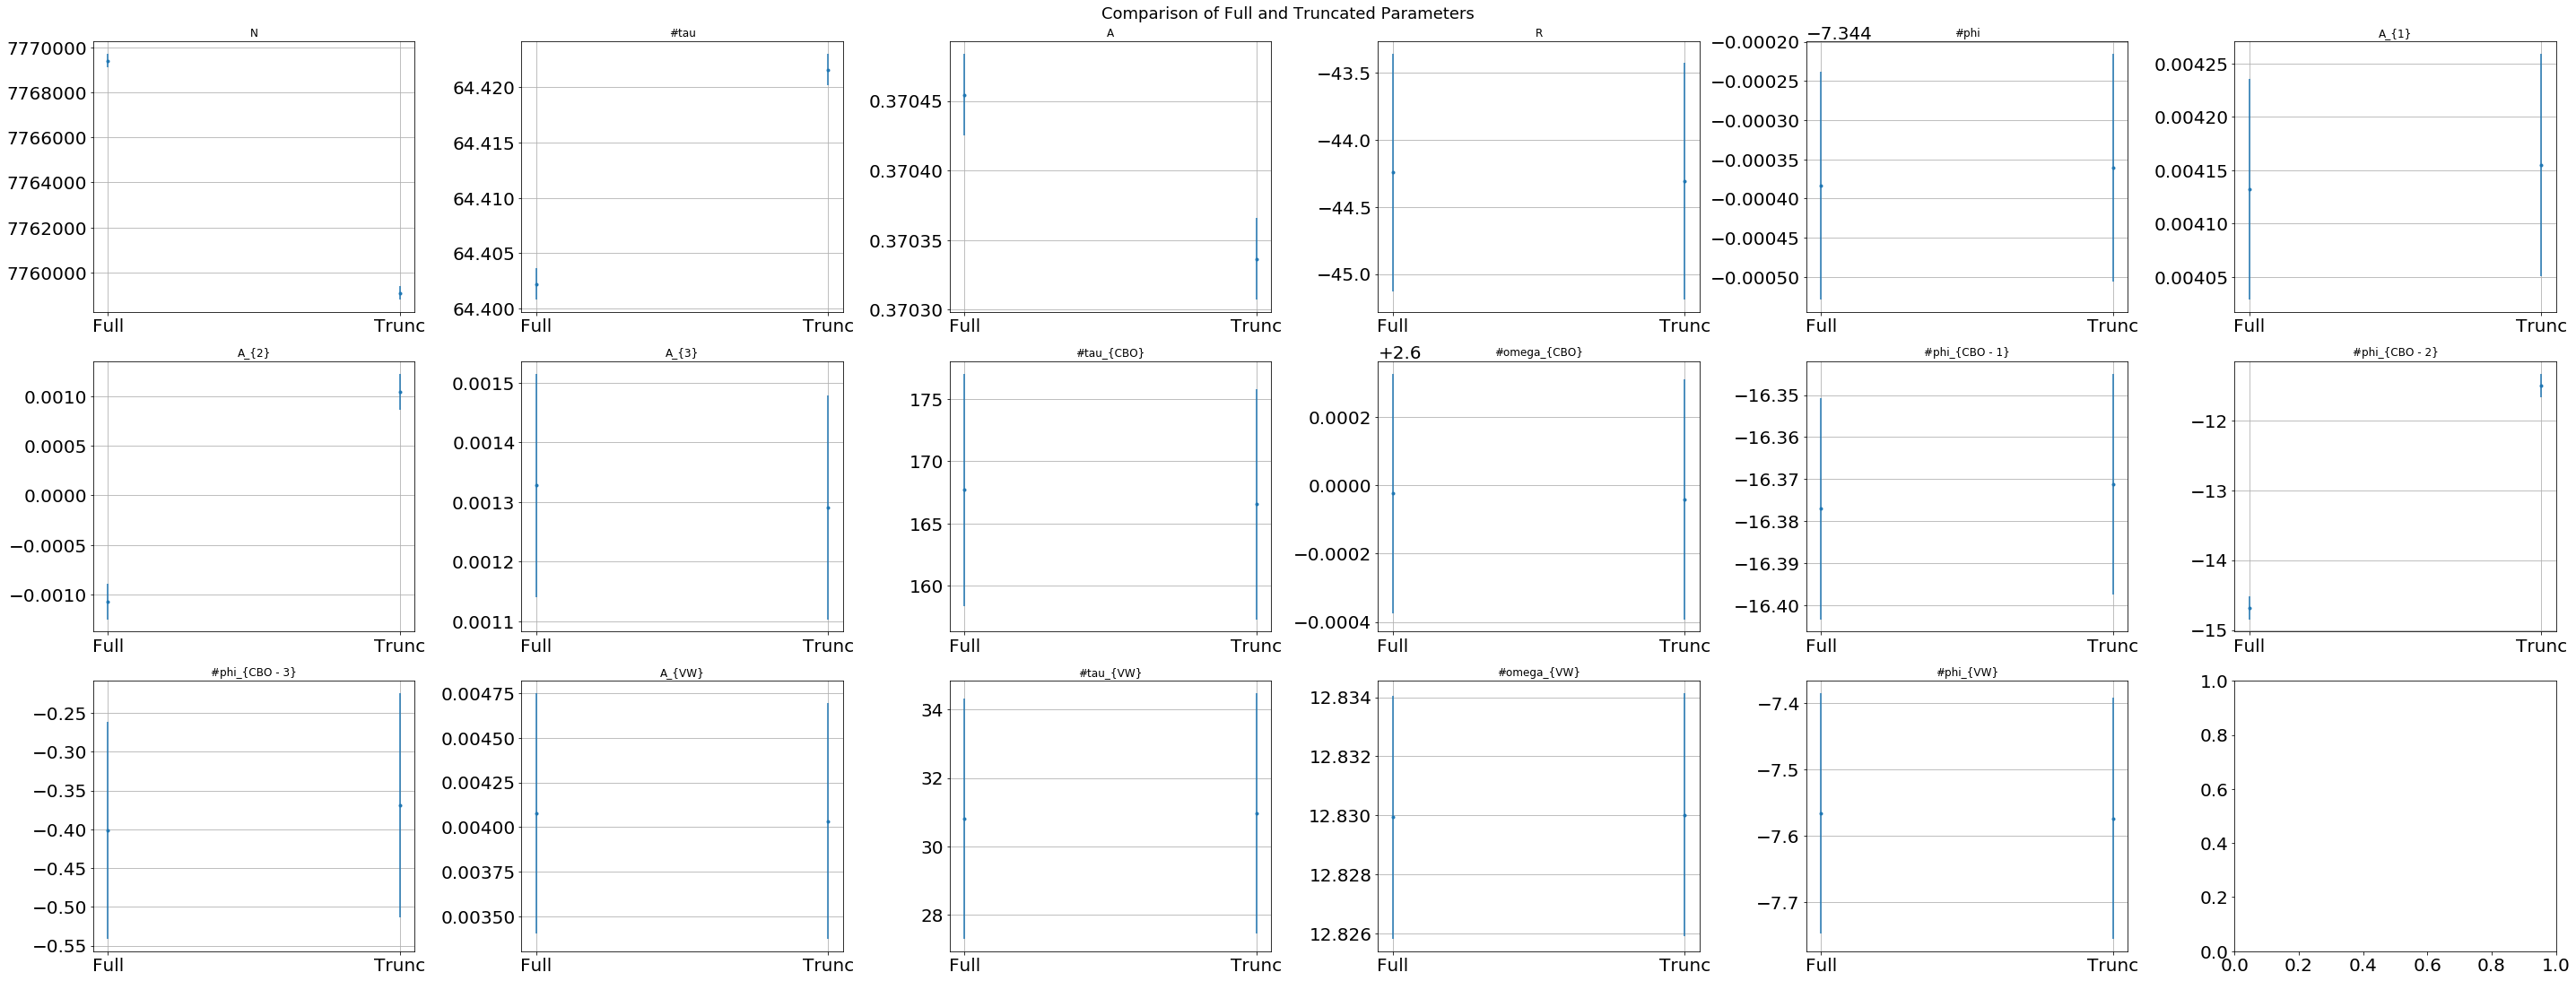

In [180]:
width = 6
height = int(np.ceil( len(parameters17Trunc) / width ) )

fig, ax = plt.subplots(height, width, figsize=(40,15))
for i, fTrunc in enumerate(parameters17Trunc):
    fFull = parameters17Full[i]
    print(fTrunc, fFull)
    axi = ax[int(np.floor(i / width))][i % width]
    
    pars = [fFull[0], fTrunc[0]]
    parErrs = [fFull[1], fTrunc[1]]
    
    axi.errorbar( [x for x in range(len(fFull))], pars, xerr=0, yerr=parErrs, fmt=".")
    axi.set_title(func17Trunc.GetParName(i))
    plt.sca(axi)
    plt.grid()
    plt.xticks(np.arange(2), ('Full', 'Trunc'))

plt.suptitle("Comparison of Full and Truncated Parameters", y=1.01, size=18)
plt.tight_layout()
plt.show()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


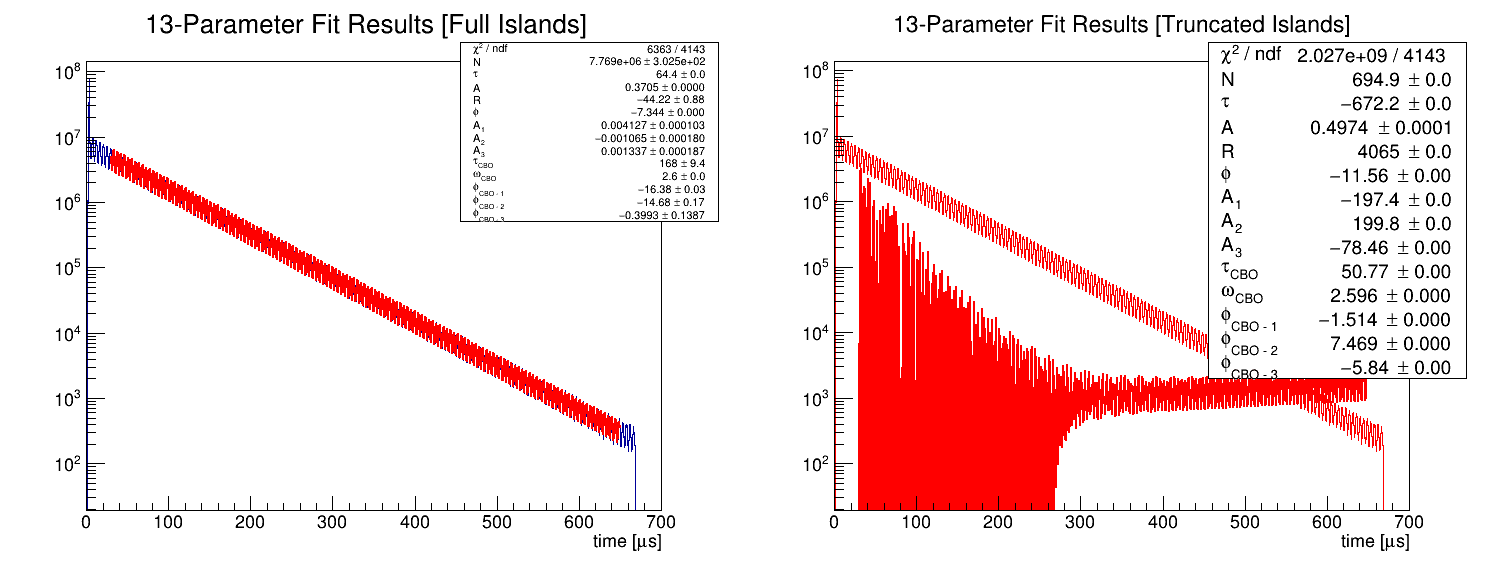

In [181]:
c = r.TCanvas("c","c",1500,600)
c.Divide(2)

c.cd(1)
w1_13.SetTitle("13-Parameter Fit Results [Full Islands]")
w1_13.Draw()
r.gPad.SetLogy()

c.cd(2)
w2_13.SetTitle("13-Parameter Fit Results [Truncated Islands]")
w2_13.Draw()
r.gPad.SetLogy()

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


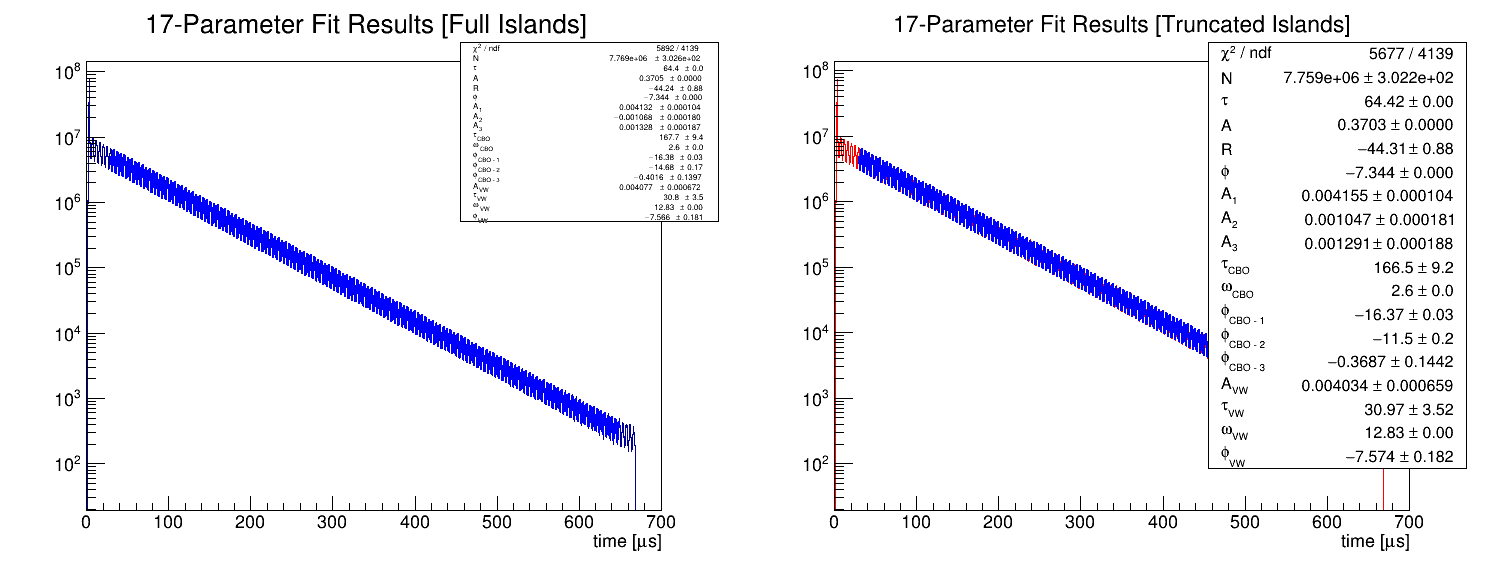

In [182]:
c = r.TCanvas("c","c",1500,600)
c.Divide(2)

c.cd(1)
w1_17.SetTitle("17-Parameter Fit Results [Full Islands]")
w1_17.Draw()
r.gPad.SetLogy()

c.cd(2)
w2_17.SetTitle("17-Parameter Fit Results [Truncated Islands]")
w2_17.Draw()
r.gPad.SetLogy()

c.Draw()

In [183]:
print("chiSq / NDF Full:", func17Full.GetChisquare(),"/", func17Full.GetNDF(),"=", func17Full.GetChisquare() / func17Full.GetNDF())
print("chiSq / NDF Trunc:", func17Trunc.GetChisquare(),"/", func17Trunc.GetNDF(),"=", func17Trunc.GetChisquare() / func17Trunc.GetNDF())

chiSq / NDF Full: 5891.616432415815 / 4139 = 1.4234395826083148
chiSq / NDF Trunc: 5676.676628614167 / 4139 = 1.3715092120353147


In [184]:
print("R Value Full:", func17Full.GetParameter(3), "+/-",  func17Full.GetParError(3) )
print("R Value Truncated:", func17Trunc.GetParameter(3), "+/-",  func17Trunc.GetParError(3) )

print("delta R = ",  func17Full.GetParameter(3) - func17Trunc.GetParameter(3) )

R Value Full: -44.244796723851145 +/- 0.8835434292756597
R Value Truncated: -44.30784531577958 +/- 0.8838376940574734
delta R =  0.06304859192843537


In [185]:
print("chiSq / NDF Full:", func17Full)

chiSq / NDF Full: <ROOT.TF1 object ("func17Full") at 0x7f9b9fad3900>


In [186]:
residDiff_5param = residuals5paramXform_FullIslands.Clone("residDiff_5param")
residDiff_5param.Add(residuals5paramXform_TruncIslands, -1)

True

In [1]:
c = r.TCanvas()
residDiff_5param.Draw("hist")
c.Draw()

NameError: name 'r' is not defined

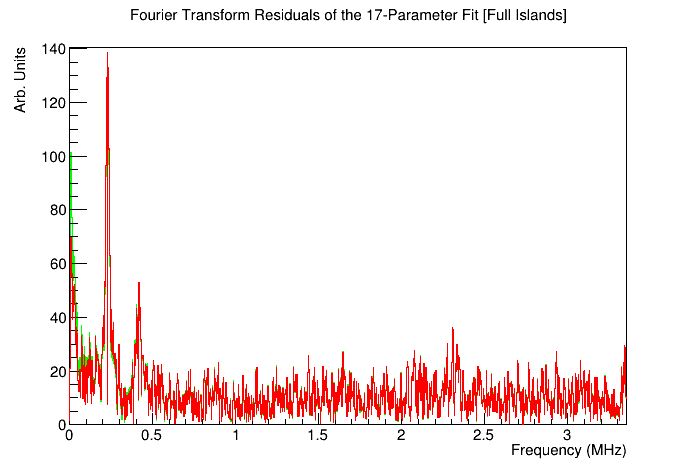

In [188]:
c = r.TCanvas()

residuals17paramXform_FullIslands.Draw("hist")
residuals17paramXform_TruncIslands.SetLineColor(2)
residuals17paramXform_TruncIslands.Draw("hist SAME")

c.Draw()

In [189]:
residDiff_17param = residuals17paramXform_FullIslands.Clone("residDiff_17param")
residDiff_17param.Add(residuals17paramXform_TruncIslands, -1)
residDiff_17param.SetTitle("17-Parameter Residuals: Full - Trunc")

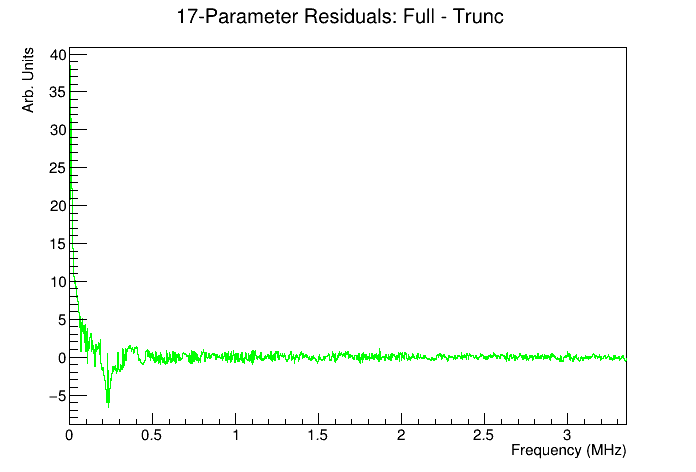

In [190]:
c = r.TCanvas()
residDiff_17param.Draw("hist")
c.Draw()